In [1]:
import os
import math
import pandas as pd
import numpy as np
import GPy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
import sklearn
from sklearn.preprocessing import StandardScaler

In [2]:
# Specify the folder path
folder_path = 'Data_ALL_1min'
file = 'combined_data.csv'
file_path = os.path.join(folder_path, file) 
df = pd.read_csv(file_path)
df.head(40)


,time,temp,tags,coordinate
0,2017-03-02 21:35:00,26.300000,SW-Ground_PH001,"(0, 0)"
1,2017-03-02 21:40:00,25.800001,SW-Ground_PH001,"(0, 0)"
2,2017-03-02 21:45:00,25.380000,SW-Ground_PH001,"(0, 0)"
3,2017-03-02 21:50:00,25.160001,SW-Ground_PH001,"(0, 0)"
4,2017-03-02 21:55:00,25.180001,SW-Ground_PH001,"(0, 0)"
5,2017-03-02 22:00:00,25.010000,SW-Ground_PH001,"(0, 0)"
6,2017-03-02 22:05:00,24.890000,SW-Ground_PH001,"(0, 0)"
7,2017-03-02 22:10:00,24.760000,SW-Ground_PH001,"(0, 0)"
8,2017-03-02 22:15:00,24.779999,SW-Ground_PH001,"(0, 0)"
9,2017-03-02 22:20:00,24.660001,SW-Ground_PH001,"(0, 0)"


In [3]:
df = df[~df['tags'].str.contains('SE-')]

In [4]:
# Convert string representation of tuple to tuple
df['coordinate'] = df['coordinate'].apply(ast.literal_eval)

# Split 'coordinate' column into 'X' and 'Y' columns
df['X'], df['Y'] = zip(*df['coordinate'])

# Convert 'X' and 'Y' to integers
df['X'] = df['X'].astype(int)
df['Y'] = df['Y'].astype(int)

In [5]:
df_new = df[['X', 'Y', 'time', 'temp']]
df_new = df_new.sort_values(by=['time', 'X', 'Y'])
df_new['time'] = pd.to_datetime(df_new['time'])
df_new['time'] = df_new['time'].apply(lambda x: x.timestamp())

In [6]:
data = df_new[['X', 'Y', 'time', 'temp']].values

In [7]:
start = 125 + 12*24
end = 12*48 + start

In [8]:
data = data[15*start:,]
data[:,2] -= data[0,2]
data[:,2] /= 60

In [9]:
X_grid = data[:15,:2]

In [ ]:
# hyperparameter intialization

variance_s = 0.5
lengthscale_s = 2
variance_t = 0.5
lengthscale_t = 0.025
period = 150

In [ ]:
seed_number = 8
np.random.seed(seed_number)

timestep = np.unique(data[:,2])
x_min, x_max = 0,2
y_min, y_max = 0,4
n_x = 3
n_y = 5

# create a grid of location coordinates
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, n_x),
                            np.linspace(y_min, y_max, n_y))
locations = np.column_stack((x_grid.ravel(), y_grid.ravel()))
# Generate initial training data|
n_train = 2
# X_train = np.random.randint(low=0, high=[x_max+1,y_max+1], size=(n_train, 2))
np.random.shuffle(locations)

# Generate new measurement locations over time
n_meas = end - start
n_iter = 2
rmse_array = np.zeros(n_meas)

Y_pred_array = np.zeros((n_meas, n_x*n_y))
Y_std_array = np.zeros((n_meas, n_x*n_y))

In [12]:
X_train = np.zeros((n_iter*n_meas, 3))
y_train = np.zeros(n_iter*n_meas)
idx_train = np.zeros(n_iter*n_meas)
for i in range(n_meas):
    t_curr = timestep[i]
    idx_curr = np.where(data[:,2] == t_curr)
    data_curr = data[idx_curr]
    # X_iter = np.random.randint(low=0, high=[x_max+1,y_max+1], size=(n_iter, 2))
    np.random.shuffle(locations)
    X_iter = locations[:n_train]
    X_iter = np.hstack((X_iter, np.zeros((n_iter, 1))))
    X_iter[:,2] = t_curr
    y_iter = np.zeros(n_iter)
    idx_iter = np.zeros(n_iter)
    for j in range(len(X_iter)):
        x = X_iter[j][:2]
        x_ax0 = np.where(data_curr[:,0] == x[0])
        x_ax1 = np.where(data_curr[:,1] == x[1])
        idx = np.intersect1d(x_ax1, x_ax0)
        y_iter[j] = data_curr[idx,3]
        idx_iter[j] = idx
    idx_train[i*n_iter:(i+1)*n_iter] = idx_iter
    X_train[i*n_iter:(i+1)*n_iter] = X_iter
    y_train[i*n_iter:(i+1)*n_iter] = y_iter
    
# Initialize incremental scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_train_scaled = scaler_X.fit_transform(X_train)  # X includes spatial and temporal features
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1))

In [ ]:
# define the spatial and temporal kernels
spatial_kernel = GPy.kern.Matern52(input_dim=2, active_dims=[0, 1], lengthscale=1.0, ARD=True, variance=0.1)
temporal_kernel = GPy.kern.Exponential(input_dim=1, active_dims=[2], lengthscale=1.0, variance=1.0)

# define the Gaussian process model with a Product kernel
gp_kernel = spatial_kernel * temporal_kernel
model_sim = GPy.models.GPRegression(X_train_scaled[:n_iter], y_train_scaled[:n_iter].reshape(-1,1), kernel=gp_kernel)

spatial_kernel_lengthscale_array = np.zeros((n_meas, 2))
spatial_kernel_variance_array = np.zeros(n_meas)
temporal_kernel_lengthscale_array = np.zeros(n_meas)
temporal_kernel_variance_array = np.zeros(n_meas)
Y_gt_array = np.zeros((n_meas, n_x*n_y))


In [14]:
for i in range(n_meas):
    t_curr = timestep[i]
    idx_curr = np.where(data[:,2] == t_curr)
    data_curr = data[idx_curr]
    y_curr = data_curr[:,3]
    model_sim.set_XY(X=X_train_scaled[:(i+1)*n_iter], Y=y_train_scaled[:(i+1)*n_iter].reshape(-1, 1))
    # model_sim.optimize(messages=False)

    model_sim.optimize_restarts(num_restarts=5, verbose=False)

    X_pred = np.hstack((X_grid, np.zeros((X_grid.shape[0], 1))))
    X_pred[:,2] = t_curr
    X_pred_scaled = scaler_X.transform(X_pred)
    Y_pred_scaled, Y_std = model_sim.predict(X_pred_scaled)
    Y_pred = scaler_y.inverse_transform(Y_pred_scaled)
    Y_pred = Y_pred.reshape(-1,)
    for meas in range(n_iter):
        idx_meas = int(idx_train[i*n_iter + meas])
        Y_pred[idx_meas] = y_curr[idx_meas]
    MSE = np.square(np.subtract(Y_pred,y_curr)).mean() 
    RMSE = math.sqrt(MSE)
    rmse_array[i] = RMSE
    Y_pred_array[i] = Y_pred
    Y_std_array[i] = Y_std.reshape(-1,)
    spatial_kernel_lengthscale_array[i] = model_sim.kern.Mat52.lengthscale.values
    spatial_kernel_variance_array[i] = model_sim.kern.Mat52.variance.values
    temporal_kernel_lengthscale_array[i] = model_sim.kern.Exponential.lengthscale.values
    temporal_kernel_variance_array[i] = model_sim.kern.Exponential.variance.values
    print(f'RMSE at timestep {i}: {RMSE}')
    print("Spatial Lengthscale:", model_sim.kern.Mat52.lengthscale.values)
    print("Temporal Lengthscale:", model_sim.kern.Exponential.lengthscale.values)
    # print("Temporal Lengthscale:", model_sim.kern.periodic_exponential.lengthscale.values)
    # print("Period:", model_sim.kern.periodic_exponential.period.values)
    print("Spatial Variance:", model_sim.kern.Mat52.variance.values)
    print("Temporal Variance:", model_sim.kern.Exponential.variance.values)
    # print("Temporal Variance:", model_sim.kern.periodic_exponential.variance.values)
    Y_gt_array[i] = y_curr
    


 /Users/weiliang/opt/anaconda3/lib/python3.9/site-packages/GPy/core/__init__.py:80: FutureWarning:In the future `np.bool` will be defined as the corresponding NumPy scalar.


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
np.mean(rmse_array)

0.19038045201024797

In [ ]:
output_file = f'gp_results_seed_{seed_number}.npz'
np.savez(output_file, rmse_array=rmse_array, Y_gt_array=Y_gt_array, Y_pred_array=Y_pred_array, Y_std_array=Y_std_array)

In [ ]:
# Concatenate the arrays along the second axis
combined_array = np.column_stack((rmse_array, spatial_kernel_lengthscale_array, spatial_kernel_variance_array, temporal_kernel_lengthscale_array, temporal_kernel_variance_array))

# Define the output file name
output_file = f'combined_data_seed_{seed_number}.csv'

# Save the combined array to a CSV file
np.savetxt(output_file, combined_array, delimiter=',', header='RMSE,Spatial_Lengthscale_1,Spatial_Lengthscale_2,Spatial_Variance,Temporal_Lengthscale,Temporal_Variance', comments='')

In [ ]:
output_file = f'rmse_array_seed_{seed_number}.csv'
np.savetxt(output_file, rmse_array, delimiter=',')

In [ ]:
def plot_meshgrid(data, x, y):
    plt.imshow(data, cmap='viridis', origin='lower', extent=[0, x, 0, y])
    plt.colorbar()
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Data on Meshgrid')
    plt.show()

In [ ]:
rmse_array

array([0.64018972, 0.65834523, 0.63601143, 0.68424711, 0.57064106,
       0.57930754, 0.52449577, 0.55529663, 0.54342096, 0.53780264,
       0.10587859, 0.10522051, 0.06518627, 0.07358773, 0.06057403,
       0.05809347, 0.06321094, 0.06669212, 0.05616085, 0.06772972,
       0.07773034, 0.07845613, 0.07587779, 0.08028855, 0.07622109,
       0.08041563, 0.08084613, 0.04201945, 0.04838885, 0.05796284,
       0.04910977, 0.06051084, 0.07051306, 0.06986207, 0.05342299,
       0.04991752, 0.04636627, 0.04755969, 0.05508628, 0.04931445,
       0.03894468, 0.05190473, 0.04115078, 0.04221988, 0.04658605,
       0.04449704, 0.05673209, 0.07283982, 0.04742157, 0.04611104,
       0.03923526, 0.06086345, 0.08990986, 0.30837626, 0.34171989,
       0.28330234, 0.32015666, 0.4774779 , 0.40530137, 0.1467177 ,
       0.1389619 , 0.17154586, 0.20348912, 0.29000505, 0.31062512,
       0.3737698 , 0.21900672, 0.22964334, 0.23418609, 0.23779471,
       0.24530988, 0.29633623, 0.24503111, 0.24942414, 0.32223

In [ ]:
folder_path = 'Data_ALL_1min'
file = 'combined_data_by_time_5min.csv'
file_path = os.path.join(folder_path, file) 
df_time = pd.read_csv(file_path)
df_time.head()
# df_subset = df_time.iloc[511:2*1440+511]
df_subset = df_time.iloc[start:end]
df_subset['time'] = pd.to_datetime(df_subset['time'])

 C:\Users\wliang\AppData\Local\Temp\ipykernel_16064\2554516835.py:8: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


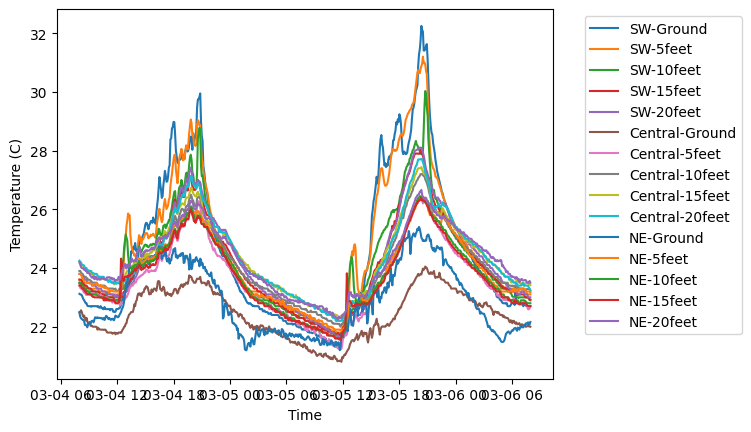

In [ ]:
Y_true_array = np.zeros_like(Y_pred_array)
counter = 0
column_labels = []
for column in df_subset.columns:
    if column != 'time' and 'SE-' not in column:
        column_label = column.split('_')[0]
        Y_true_array[:,counter] = df_subset[column].values
        counter += 1
        plt.plot(df_subset['time'], df_subset[column], label=column_label)
        column_labels.append(column_label)
        
plt.ylabel('Temperature (C)')
plt.xlabel('Time')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xticks(range(0, len(df_subset['time']), 30))
plt.show()

In [ ]:
df_subset['time'] = df_subset['time'].apply(lambda x: x.timestamp())

 C:\Users\wliang\AppData\Local\Temp\ipykernel_16064\1622686838.py:1: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_subset['time'] = df_subset['time'] - df_subset['time'].iloc[0]

 C:\Users\wliang\AppData\Local\Temp\ipykernel_16064\3331356296.py:1: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
y_train_mark = np.zeros((len(X_train), 3))
y_train_mark[:,0] = y_train
for it, ts in enumerate(df_subset['time'].values):
    for j in range(n_iter):
        sample = X_train[it*n_iter+j]
        idx_int = sample[0]*n_y + sample[1]
        y_train_mark[it*n_iter+j, 1] = ts
        y_train_mark[it*n_iter+j, 2] = idx_int

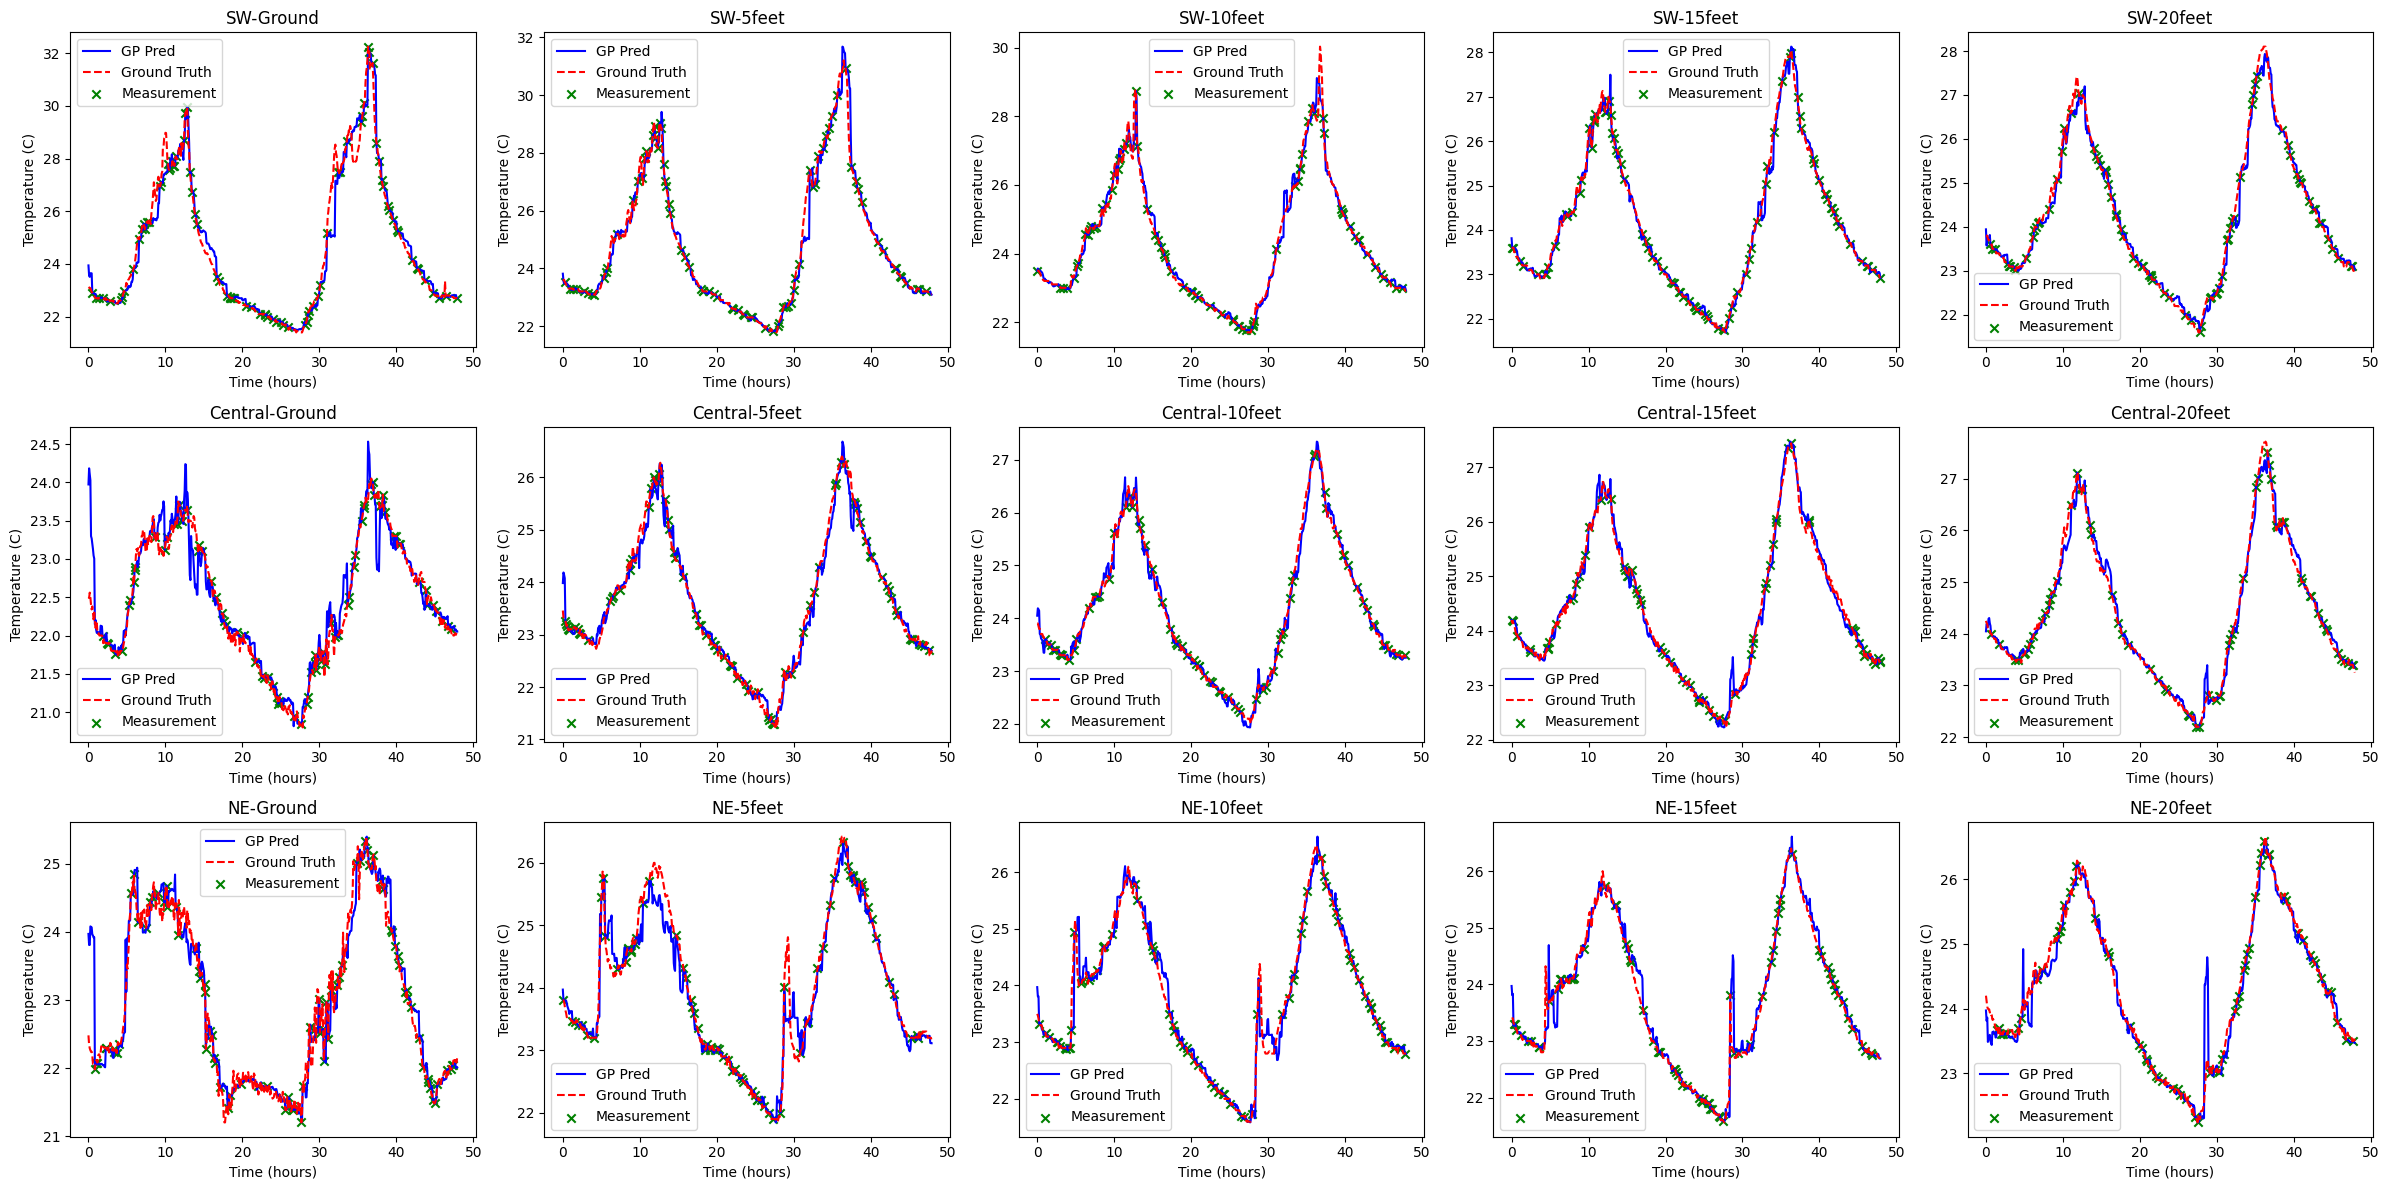

In [ ]:
# plt.ylabel('Pred (C)')
# plt.xlabel('Time')
# plt.plot(Y_pred_array[:,0])
# plt.plot(Y_true_array[:,0])I
# # plt.xticks(range(0, len(df_subset['time']), 30))


# Create a 5x3 subplot array
fig, axes = plt.subplots(3,5, figsize=(24, 12))

# Iterate over each subplot
for i, ax in enumerate(axes.flatten()):
    # Plot Y_pred_array[:,i] and Y_true_array[:,i]
    ax.plot(df_subset['time']/3600, Y_pred_array[:, i], color='blue', label='GP Pred')
    ax.plot(df_subset['time']/3600, Y_true_array[:, i], color='red', linestyle='--', label='Ground Truth')
    idx_meas = np.where(y_train_mark[:,2] == i)
    ax.scatter(y_train_mark[idx_meas,1]/3600, y_train_mark[idx_meas,0], color='green', marker='x', label='Measurement')
    ax.set_title(column_labels[i])
    ax.set_xlabel('Time (hours)')
    ax.set_ylabel('Temperature (C)')
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()